In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import optimize
import cplot  #for domain coloring
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rc('font', size=16)

# adsorption model $\mathbf{m}(\mathbf{p})$

In [2]:
# Langmuir params for MOF 1
K1 = [0.1, 0.5]
M1 = 1.0
# Langmuir params for MOF 2
K2 = [0.7, 0.3]
M2 = 2.0

def m_1(p):
    return M1 * np.dot(K1, p) / (1 + np.dot(K1, p))

def m_2(p):
    return M2 * np.dot(K2, p) / (1 + np.dot(K2, p))

In [3]:
p = np.array([1.2, -3])
np.any(p < 0) 
m_1(p)

3.6315789473684217

# inverse of adsorption model $\mathbf{p}(\mathbf{m})$

In [4]:
def p_of_m(m_0, p_lb, p_ub): 
    # we want this function to return a zero vector
    #  it takes in a pressure p
    #  it outputs the corresponding difference between the response and the response m_0 that we find
    #  if we find the right p that gives us the response m_0, then this will be the zero vector
    def f(p):
        return [m_1(p) - m_0[0], m_2(p) - m_0[1]]
    sol = optimize.root(f, [1.0, 1.0])
    p = sol.x
    # return nan if p less than lower bound, greater than upper bound
    if p[0] < p_lb or p[1] < p_lb or p[0] > p_ub or p[1] > p_ub:
        return np.array([np.nan, np.nan])
    if not sol.success:
        return np.array([np.nan, np.nan])
#     assert np.all(np.isclose([m_1(p), m_2(p)], m_0))
    return p

p_of_m([0.2, 0.5], 0, 5)

array([0.28645833, 0.44270833])

In [5]:
def get_meshgrid(x_max, y_max, nb_pts=200):
    return np.meshgrid(np.linspace(0, x_max, num=nb_pts),
                       np.linspace(0, y_max, num=nb_pts))

In [115]:
def colorFromBivariateData(x,y,cmap1 = plt.cm.Greens, cmap2 = plt.cm.YlOrRd):
    if np.any(x > 1) or np.any(y > 1):
        raise Exception("Numbers must be between 0 and 1.")
    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        return np.array([1, 1, 1, 1])
    x_color = cmap1(x)
    y_color = cmap2(y)

    # Color for each point
    xy_color = np.sum([x_color, y_color], axis=0)/2.0

    return xy_color

In [118]:
colorFromBivariateData(2,2)

Exception: Numbers must be between 0 and 1.

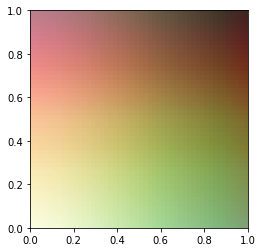

In [116]:
x = np.linspace(0, 1)
y = np.linspace(0, 1)
z = [[colorFromBivariateData(x[i], y[j]) for i in range(np.size(x))] for j in range(np.size(y))]
extent = (0, 1, 0, 1) #figure out how to put our desired x/y lims on this
plt.imshow(z, extent=extent, origin='lower')


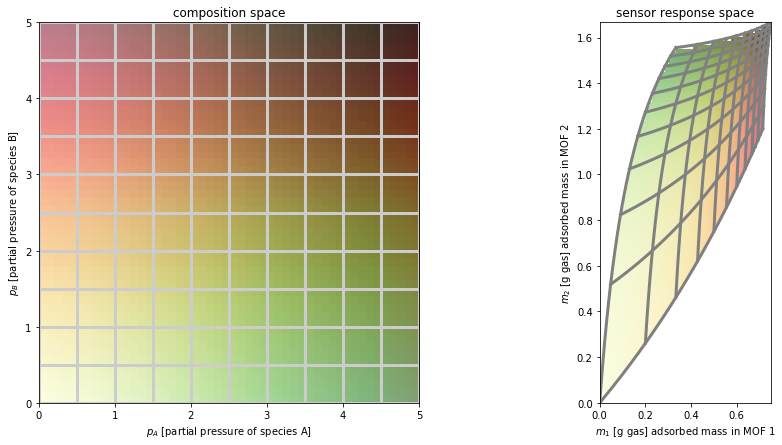

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")

# shared params
p_max = 5.0 # largest pressure we go to.

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   draw grid lines and their mapping
###
dp = 0.5 # spacing between grid lines
nb_pts = 50
# these arrays will contain the correponding reponses to each point on the lines.
m1 = np.zeros(nb_pts)
m2 = np.zeros(nb_pts)
for i in range(int(p_max / dp)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    p_a = i * dp # p_a is constant here.
    # plot the line in composition space
    ax[0].plot([p_a, p_a], [0, p_max], color="0.8", lw=3)
    
    # plot the image of the line in sensor response space
    p_b = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = np.array([p_a, p_b[j]])
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
        m1[j] = m_1(p_on_line)
        m2[j] = m_2(p_on_line)
    ax[1].plot(m1, m2, color="gray", lw=3)
    
    ###
    #   y = constant (horizontal) grid lines
    ###
    p_b = i * dp # p_b is constant here.
    # plot the line in composition space
    ax[0].plot([0, p_max], [p_b, p_b], color="0.8", lw=3)
    
    # plot the image of the line in sensor response space
    p_a = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = np.array([p_a[j], p_b])
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
        m1[j] = m_1(p_on_line)
        m2[j] = m_2(p_on_line)
    ax[1].plot(m1, m2, color="gray", lw=3)
    
    
###
#   color the plane
#   color represents.
###
pa = np.linspace(0, p_max)
pb = np.linspace(0, p_max)
z_composition = [[colorFromBivariateData(pa[i]/p_max, pb[j]/p_max) for i in range(np.size(pa))] for j in range(np.size(pb))]

m_max = [m_1([p_max,p_max]), m_2([p_max,p_max])]
num_grid_pts = 100
m1_grid = np.linspace(0, m_max[0], num_grid_pts)
m2_grid = np.linspace(0, m_max[1], num_grid_pts)

z_response = [[colorFromBivariateData(0, 0) for i in range(num_grid_pts)] for j in range(num_grid_pts)]
for i in range(num_grid_pts):
    for j in range(num_grid_pts):
        m_0 = [m1_grid[i], m2_grid[j]]
        p = p_of_m(m_0, 0, p_max) 
        z_response[j][i] = colorFromBivariateData(p[0]/p_max, p[1]/p_max)

extent_composition = (0, p_max, 0, p_max) 
extent_response = (0, m_max[0], 0, m_max[1])

ax[0].imshow(z_composition, extent=extent_composition, origin='lower')        
ax[1].imshow(z_response, extent=extent_response,  origin='lower') # need to figure out how to map extent to grid lines
            
ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')

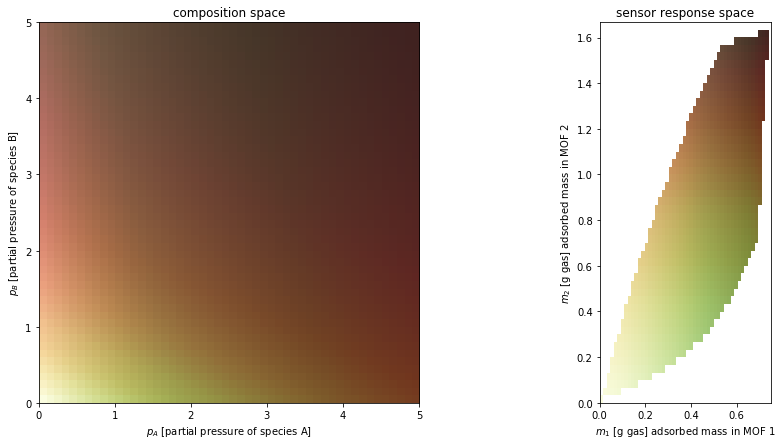

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")

#using m_max from cell above

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   draw grid lines and their mapping
###
dm = 0.1 # spacing between grid lines
nb_pts = 50
# these arrays will contain the correponding compositions to each point on the lines.
p_a = np.zeros(nb_pts)
p_b = np.zeros(nb_pts)

# for i in range(int(m_max / dm)+1):
#     ###
#     #   x = constant (vertical) grid lines
#     ###
#     m1 = i * dm # m2 is constant here.
#     # plot the line in composition space
#     # TODO: need to do something with this to get rid of gray lines in white spaces in sensor response space
#     ax[1].plot([m1, m1], [0, m_max], color="0.8", lw=3)  
    
#     # plot the image of the line in composition space
#     m2 = np.linspace(0.0, m_max, nb_pts)

#     # loop through points on the line
#     for j in range(nb_pts):
#         # get vector on this line
#         m_on_line = np.array([m1, m2[j]])
#         # compute the composition in the gas space when MOFs have this much gas absorbed
#         p_a[j], p_b[j] = p_of_m(m_on_line, 0, np.Inf) ### is -1.001 an okay value for p_lb?
#     ax[0].plot(p_a, p_b, color="gray", lw=3)

#     ###
#     #   y = constant (horizontal) grid lines
#     ###
#     m2 = i * dm # m1 is constant here.
#     # plot the line in composition space
#     ax[1].plot([0, m_max], [m2, m2], color="0.8", lw=3)

#     # plot the image of the line in composition space
#     m1 = np.linspace(0.0, m_max, nb_pts)
    
#     # loop through points on the line
#     for j in range(nb_pts):
#         # get vector on this line
#         m_on_line = np.array([m1[j], m2])
#         # compute the composition in the gas space when MOFs have this much gas absorbed
#         p_a[j], p_b[j] = p_of_m(m_on_line, 0, np.Inf)  ### is -1.001 an okay value for p_lb?
#     ax[0].plot(p_a, p_b, color="gray", lw=3)
    
###
#   color the plane
#   color represents.
###
m1 = np.linspace(0, m_max[0])
m2 = np.linspace(0, m_max[1])
z_response = [[colorFromBivariateData(m1[i]/m_max[0], m2[j]/m_max[1]) for i in range(np.size(m1))] 
                 for j in range(np.size(m2))]

for i in range(np.shape(z_response)[0]):
    for j in range(np.shape(z_response)[1]):
        m_0 = [m1[i], m2[j]]
        p = p_of_m(m_0, 0, np.Inf) 
        # zero out responses that correspond to negative pressures
        if np.any(np.isnan(p)) or np.any(p > p_max):
            z_response[i][j] = np.array([1, 1, 1, 1])


#m_max = [m_1([p_max,p_max]), m_2([p_max,p_max])]
#num_grid_pts = 100
#m1_grid = np.linspace(0, m_max[0], num_grid_pts)
#m2_grid = np.linspace(0, m_max[1], num_grid_pts)

# for i in range(num_grid_pts):
#     for j in range(num_grid_pts):
#         m_0 = [m1_grid[i], m2_grid[j]]
#         p = p_of_m(m_0, 0, p_max) 
#         z_response[j][i] = colorFromBivariateData(p[0]/p_max, p[1]/p_max)



ax[1].imshow(z_response, extent=extent_response,  origin='lower') # need to figure out how to map extent to grid lines
            
# ax[1].set_aspect('equal', 'box')
# ax[0].set_aspect('equal', 'box')    
    
# ##
#   color the plane
#   color represents.
# ##

# lay a grid in response and composition space
# m1, m2 = get_meshgrid(m_max, m_max)
# pa, pb = get_meshgrid(ax[0].get_xlim()[1], ax[0].get_ylim()[1])

# z_response = np.sqrt(m1 ** 2 + m2 ** 2)

# for i in range(np.shape(z_response)[0]):
#     for j in range(np.shape(z_response)[1]):
#         m_0 = [m1[i, j], m2[i, j]]
#         p = p_of_m(m_0, 0, np.Inf) 
#         if np.any(np.isnan(p)):
#             z_response[i, j] = np.nan
#         else:
#             z_response[i, j] = np.linalg.norm(m_0)


for i in range(np.shape(z_composition)[0]):
    for j in range(np.shape(z_composition)[1]):
        p_0 = np.array([pa[i], pb[j]])
        m = np.array([m_1(p_0), m_2(p_0)])
        if np.any(m > m_max):
            z_composition[i][j] = np.array([1, 1, 1, 1])
        else:
            z_composition[i][j] = colorFromBivariateData(m[0]/m_max[0], m[1]/m_max[1])   

ax[0].imshow(z_composition, extent=extent_composition, origin='lower')        

ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')

# # set composition space to exclude negative pressures 
#ax[0].set_xlim(xmin=0)
#ax[0].set_ylim(ymin=0)

# TODO 
# Add grid lines to response and composition space (make them white where sensor response spacce is white, 
# something about how pressure is colored white then colored?)
# Add boarder around response space (this will be a line stored as points and plotted on ax[1])
# (something about as pa -> 1, keep pb =0)

# Messing around with domain coloring

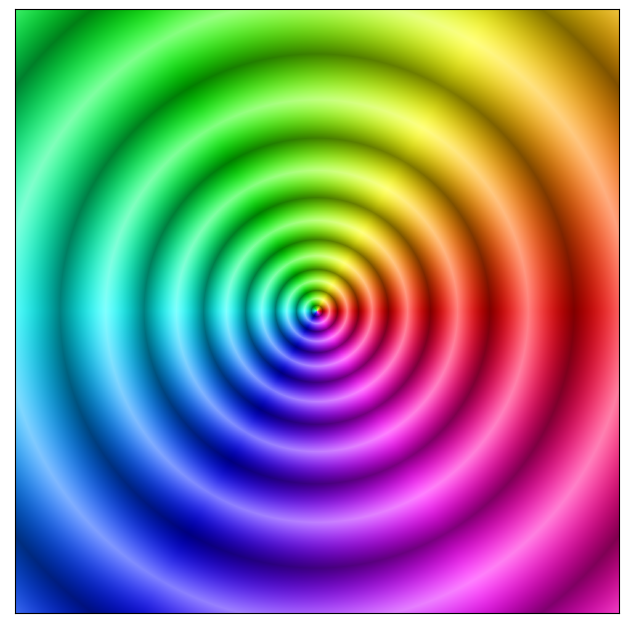

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import hsv_to_rgb

class DColor:
    def __init__(self, samples=3500, xmin=-10, xmax=10, ymin=-10, ymax=10):
        #plot settings
        self._samples = samples
        #axes
        self._xmin = xmin
        self._xmax = xmax
        self._ymin = ymin
        self._ymax = ymax
        self.makeDomain()

    def makeDomain(self):
        """Create the domains for Real (x) and Imaginary (y) values respectively"""
        x = np.linspace(self._xmin, self._xmax, self._samples)
        y = np.linspace(self._ymin, self._ymax, self._samples)
        self.xx, self.yy=np.meshgrid(x,y)

    def makeColorModel(self, zz):
        """Create the HSV color model for the function domain that will be plotted"""
        H = self.normalize(np.angle(zz) % (2. * np.pi)) #Hue determined by arg(z)
        r = np.log2(1. + np.abs(zz))
        S = (1. + np.abs(np.sin(2. * np.pi * r))) / 2.
        V = (1. + np.abs(np.cos(2. * np.pi * r))) / 2.

        return H,S,V

    def normalize(self, arr):
        """Used for normalizing data in array based on min/max values"""
        arrMin = np.min(arr)
        arrMax = np.max(arr)
        arr = arr - arrMin
        return arr / (arrMax - arrMin)

    def plot(self, f, xdim=10, ydim=8, plt_dpi=100):
        """Plot a complex-valued function
            Arguments:
            f -- a (preferably) lambda-function defining a complex-valued function
            Keyword Arguments:
            xdim -- x dimensions
            ydim -- y dimensions
            plt_dpi -- density of pixels per inch
        """
        zz=f(self.z(self.xx,self.yy))
        H,S,V = self.makeColorModel(zz)
        rgb = hsv_to_rgb(np.dstack((H,S,V)))

        fig = plt.figure(figsize=(xdim, ydim), dpi=plt_dpi)
        plt.imshow(rgb)
        plt.gca().invert_yaxis() #make CCW orientation positive
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        plt.show()

    def z(self, x, y):
        """return complex number x+iy
            If inputs are arrays, then it returns an array with corresponding x_j+iy_j values
        """
        return x+1j*y

dc = DColor(xmin=-10, xmax=10, ymin=-10, ymax=10, samples=4000)
#dc.plot(lambda z : (z**5+1j*z**4+z**3+1j*z**2+z+1j+1)/np.sin(z))
#dc.plot(lambda z : 2j*z**2+2j+z)
#dc.plot(lambda z : (1/(1-1j*z))-(1+1j*z))
#dc.plot(lambda z : z**3)
#dc.plot(lambda z : ((z+1-2j)*(z+2+2j)*((z-2)**2))/(z**3))
dc.plot(lambda z : z)

C:\Users\rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


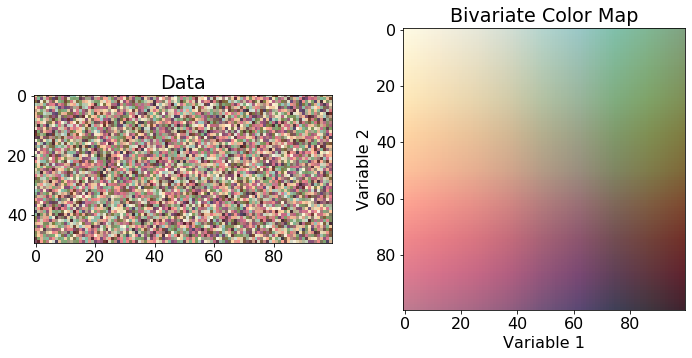

In [54]:


z1 = np.random.random((50,100))
z2 = np.random.random((50,100))
Z_color = colorFromBivariateData(z1,z2)

xx, yy = np.mgrid[0:100,0:100]
C_map = colorFromBivariateData(xx,yy)

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Z_color)
ax1.set_title('Data')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(C_map)
ax2.set_title('Bivariate Color Map')
ax2.set_xlabel('Variable 1')
ax2.set_ylabel('Variable 2')

fig.tight_layout()
fig.show()